In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from pprint import pprint
import time
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch.nn.init as init

<h3>Geometry</h3>

In [2]:
flag_train_sigma = False   # == True if we have to train sigma approximation model

In [3]:
# DEVICE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# PINN DEFAULT SETTING :
f_batch = 1 #12
PDE_batch_size  = 4096 * 4 * f_batch
IC_batch_size   = 4096 * 4 * f_batch
BC_batch_size   = 1024 * f_batch

# GEOMETRY
d = 20                          # [um] spazio tra le due armature del condensatore
L = 100                         # [um] z_max - z_min
h_arm = (L - d) / 2             # [um] spessore armatura
lato = 1e3                      # [um] x_max-x_min e y_max-y_min
A = lato ** 2                   # [um^2] superficie del condensatore
Resistivity = 50 * 1e6          # [ohm * um]
_sigma = 1 / Resistivity
epsilon = 8.85 * 1e-9           # wrt [um]   (==> espilon_relative = 1 not = 5.7)
C = epsilon * A / d             # capacità vera
C_2 = epsilon * A / L           # capacità aggiuntiva
R = Resistivity * 2*h_arm / A   # resistenza
tau = R * C + R * C_2           # [ns]
tau_pde = epsilon / _sigma      # [ns]

print(f"R : {R} , C : {C} , C2 : {C_2} , tau=R(C+C2) : {tau}") 
print(f"tau_pde=epsilon/sigma : {tau_pde} , sigma : {_sigma} , epsilon : {epsilon}")


x_min = -lato/2
x_max = +lato/2
y_min = -lato/2
y_max = +lato/2
z_min = -L/2
z_max = +L/2
factor_x, factor_y, factor_z = x_max-x_min, y_max-y_min, z_max-z_min
factor_max = np.max( [x_max-x_min, y_max-y_min, z_max-z_min] )

t_min = 0
t_max = 5 * tau               # almost complete charge of capacitor
factor_t = (t_max-t_min)
c_time_err = 1e-2
logt_min = np.log( t_min + c_time_err )
logt_max = np.log( t_max + c_time_err )
factor_logt = logt_max-logt_min


V0 = 1
E0 = V0 / ( z_max - z_min )


# NORMALIZATION
def Norm_time(time_coords):
    if isinstance(time_coords, torch.Tensor):
        return ( torch.log( time_coords + c_time_err ) ) / factor_logt
    else:
        return ( np.log( time_coords + c_time_err ) ) / factor_logt

def Norm_space(space_coords):
    if isinstance(space_coords, torch.Tensor):
        return ( space_coords - torch.tensor([x_min, y_min, z_min], device=space_coords.device) ) \
                            / torch.tensor([factor_x, factor_y, factor_z], device=space_coords.device)
    else:
        return ( space_coords - np.array([x_min, y_min, z_min]) ) / np.array([factor_x, factor_y, factor_z])

def Norm_x(x_coord):
    return ( x_coord - x_min ) / factor_x

def Norm_y(y_coord):
    return ( y_coord - y_min ) / factor_y

def Norm_z(z_coord):
    return ( z_coord - z_min ) / factor_z

def Norm_coords(coords):
    time_coords = coords[:, 0]
    space_coords = coords[:, 1:]
    if isinstance(coords, torch.Tensor):
        norm_t   = Norm_time(time_coords).unsqueeze(-1)
        norm_xyz = Norm_space(space_coords)
        return torch.cat([norm_t, norm_xyz], dim=1)
    else:
        norm_t   = Norm_time(time_coords)[:, np.newaxis]
        norm_xyz = Norm_space(space_coords)
        return np.concatenate([norm_t, norm_xyz], axis=1)

# INVERSE OF NORMALIZATION
def Inv_Norm_time(norm_time_coords):
    if isinstance(norm_time_coords, torch.Tensor):
        return ( torch.exp(norm_time_coords * factor_logt) - c_time_err )
    else:
        return ( np.exp(norm_time_coords * factor_logt) - c_time_err )

def Inv_Norm_space(norm_space_coords):
    if isinstance(norm_space_coords, torch.Tensor):
        return norm_space_coords * torch.tensor([factor_x, factor_y, factor_z], device=norm_space_coords.device) \
                + torch.tensor([x_min, y_min, z_min], device=norm_space_coords.device)
    else:
        return norm_space_coords * np.array([factor_x, factor_y, factor_z]) \
                + np.array([x_min, y_min, z_min])

def Inv_Norm_x(norm_x_coord):
    return norm_x_coord * factor_x + x_min

def Inv_Norm_y(norm_y_coord):
    return norm_y_coord * factor_y + y_min

def Inv_Norm_z(norm_z_coord):
    return norm_z_coord * factor_z + z_min

def Inv_Norm_coords(norm_coords):
    norm_time_coords = norm_coords[:, 0]
    norm_space_coords = norm_coords[:, 1:]
    if isinstance(norm_coords, torch.Tensor):
        time_coords = Inv_Norm_time(norm_time_coords).unsqueeze(-1)
        space_coords = Inv_Norm_space(norm_space_coords)
        return torch.cat([time_coords, space_coords], dim=1)
    else:
        time_coords = Inv_Norm_time(norm_time_coords)[:, np.newaxis]
        space_coords = Inv_Norm_space(norm_space_coords)
        return np.concatenate([time_coords, space_coords], axis=1)



normed = Norm_coords( torch.tensor([t_min, x_min, y_min, z_min], device=device).unsqueeze(0) )
norm_t_min, norm_x_min, norm_y_min, norm_z_min = normed[0,0], normed[0,1], normed[0,2], normed[0,3]
normed = Norm_coords( torch.tensor([t_max, x_max, y_max, z_max], device=device).unsqueeze(0) )
norm_t_max, norm_x_max, norm_y_max, norm_z_max = normed[0,0], normed[0,1], normed[0,2], normed[0,3]
print(" ")
print("real coordinates:")
print(f"time : [{t_min},{t_max}], space : [{x_min},{x_max}]x[{y_min},{y_max}]x[{z_min},{z_max}]")
print("normalized coordinates:")
print(f"time : [{norm_t_min},{norm_t_max}], space : [{norm_x_min},{norm_x_max}]x[{norm_y_min},{norm_y_max}]x[{norm_z_min},{norm_z_max}]")

print(" ")
print("prova normalizzazioni errori")
VVV = torch.rand((2,4), device=device)
print(VVV - Norm_coords(Inv_Norm_coords(VVV)))
print(VVV - Inv_Norm_coords(Norm_coords(VVV)))

R : 4000.0 , C : 0.0004425 , C2 : 8.85e-05 , tau=R(C+C2) : 2.124
tau_pde=epsilon/sigma : 0.4425 , sigma : 2e-08 , epsilon : 8.85e-09
 
real coordinates:
time : [0,10.620000000000001], space : [-500.0,500.0]x[-500.0,500.0]x[-50.0,50.0]
normalized coordinates:
time : [-0.6608220338821411,0.3391778767108917], space : [0.0,1.0]x[0.0,1.0]x[0.0,1.0]
 
prova normalizzazioni errori
tensor([[ 1.4901e-08,  0.0000e+00, -7.4506e-09,  0.0000e+00],
        [ 0.0000e+00,  1.4901e-08,  0.0000e+00, -1.4901e-08]], device='cuda:0')
tensor([[-2.9802e-08, -3.9160e-05, -2.6770e-05,  5.0068e-06],
        [-1.4901e-08,  3.9816e-05, -6.1393e-06, -1.0058e-06]], device='cuda:0')


<h1>Sigma ML</h1>

In [4]:
def get_sigmoid(value):
    # SMOOTH :
    #mu = factor_z/2
    #sigmoid = 1 / ( 1 + torch.exp( 4 - mu * value ))
    # NON SMOOTH ok :
    #mu = factor_z/2 * 2
    #sigmoid = 1 / ( 1 + torch.exp( 9 - mu * value ))
    mu = factor_z/2 * 2.5
    sigmoid = 1 / ( 1 + torch.exp( 14 - mu * value ))
    return sigmoid

def generate_sigma_coords(n_points=PDE_batch_size):
    t_coords = norm_t_min + (norm_t_max - norm_t_min) * torch.rand(n_points, 1, device=device)
    x_coords = norm_x_min + (norm_x_max - norm_x_min) * torch.rand(n_points, 1, device=device)
    y_coords = norm_y_min + (norm_y_max - norm_y_min) * torch.rand(n_points, 1, device=device)
    z_coords = norm_z_min + (norm_z_max - norm_z_min) * torch.rand(n_points, 1, device=device)
    points = torch.cat( [t_coords, x_coords, y_coords, z_coords], dim=-1 )
    mask = (points[:,3] > Norm_z( z_max-L/2 )) | (points[:,3] < Norm_z( z_min+L/2 ))
    sigma_coords = torch.zeros_like(points[:,0].unsqueeze(-1), device=device)
    sigma_coords[mask] = torch.ones_like(sigma_coords[mask], device=device)
    sigma_coords = sigma_coords * get_sigmoid( torch.abs(points[:,3].unsqueeze(-1) - Norm_z( z_max-L/2 )) ) \
                                * get_sigmoid( torch.abs(points[:,3].unsqueeze(-1) - Norm_z( z_min+L/2 )) )
    return points, sigma_coords


if flag_train_sigma == True:
    # PLOTs
    points, sigma_coords = generate_sigma_coords(10000)
    # plane XZ
    x_coords = Inv_Norm_x( points[:,1] )
    z_coords = Inv_Norm_z( points[:,3] )
    x_coords = x_coords.detach().cpu().numpy()
    z_coords = z_coords.detach().cpu().numpy()
    sigma_coords = sigma_coords.detach().cpu().numpy()
    # plots
    fig = plt.scatter(x_coords, z_coords, c=sigma_coords, s=2)
    plt.title("Sigma values")
    plt.xlabel("x")
    plt.ylabel("z")
    plt.colorbar(fig)
    plt.show()
    
    plt.scatter( z_coords, sigma_coords, c="green", s=1 )
    plt.axvline(x=-d/2, color="red", linestyle="--", linewidth=1.5)
    plt.axvline(x=d/2,  color="red", linestyle="--", linewidth=1.5)
    plt.xlabel("z")
    plt.ylabel("V")
    plt.show()

In [5]:
###### SIGMA DNN model

class DNN_model(nn.Module):
    
    def __init__(self, input_dim, n_nodes, n_layers, n_batches, dropout):
        super().__init__()  
        # DNN part
        self.n_batches = n_batches
        self.dropout = dropout
        layers = [nn.Linear(input_dim, n_nodes), nn.ReLU(), nn.Dropout(self.dropout)]
        for _ in range(n_layers - 1):
            layers.append(nn.Linear(n_nodes, n_nodes))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(self.dropout))
        layers.append(nn.Linear(n_nodes, 1))
        layers.append(nn.ReLU())
        self.network = nn.Sequential(*layers)
        # Xavier initialization
        for layer in self.network:
            if isinstance(layer, nn.Linear):
                init.xavier_normal_(layer.weight, gain=1.0)
                init.zeros_(layer.bias)

    def forward(self, x):
        return self.network(x)
  
    def train_model(self, optimizer, loss_function, epochs=500, batch_size=4096, validation_split=0.1):
        print("Training in progress...")
        start_time = time.time()
        n_train_batches = int( (1 - validation_split) * self.n_batches)
        n_val_batches   = self.n_batches - n_train_batches
        print(f"  number of epochs             : {epochs}")
        print(f"  number of train batches      : {n_train_batches}")
        print(f"  number of validation batches : {n_val_batches}")
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20)
        history = []
        
        for epoch in range(epochs):
            start = time.time()
            
            # === TRAINING STEP ===
            self.train()
            start_data_tr = time.time()
            data_total_loss = 0            
            for indx_batch in range(n_train_batches):
                optimizer.zero_grad()
                data_coords, target = generate_sigma_coords(batch_size)
                data_coords.requires_grad=True
                predictions = self.forward(data_coords)
                loss = loss_function( predictions, target )
                loss.backward()
                optimizer.step()
                data_total_loss += loss.item()
            data_total_loss /= n_train_batches
            end_data_tr = time.time()

            # === VALIDATION STEP ===
            self.eval()
            start_val = time.time()
            data_val_loss = 0
            with torch.no_grad():
                for indx_batch in range(n_val_batches):
                    optimizer.zero_grad()
                    data_coords, target = generate_sigma_coords(batch_size)
                    data_coords.requires_grad=True
                    predictions = self.forward(data_coords)
                    loss = loss_function( predictions, target )
                    data_val_loss += loss.item()
                data_val_loss /= n_val_batches
            end_val = time.time()
            scheduler.step(data_val_loss)

            end = time.time()
            print(f"Epoch {epoch+1}/{epochs} - data loss: {data_total_loss} - val Loss: {data_val_loss}")
            print(f"    time : {end - start} s  -  data: {end_data_tr - start_data_tr} s - val: {end_val - start_val} s")
            print(f" ")
            history.append([ data_total_loss, data_val_loss ])
            if data_total_loss < 1e-7:
                # save model
                torch.save(self.state_dict(), "sigma_model_plane3D.pth")
                print(f"Done!  (time : {time.time() - start_time})")
                return history

        # save model
        torch.save(self.state_dict(), "sigma_model_plane3D.pth")
        print(f"Done!  (time : {time.time() - start_time})")
        return history


In [6]:
# construction and training of DNN SIGMA
input_dim = 4     # (t, x, y, z)
n_nodes = 64
n_layers = 5
n_batches = 96
dropout = 0
sigma_model = DNN_model( input_dim, n_nodes, n_layers, n_batches, dropout ).to(device)

if flag_train_sigma == True:
    optimizer = torch.optim.Adam(sigma_model.parameters(), lr=0.001, weight_decay=1e-8)
    loss_function = nn.MSELoss()
    history_sigma = sigma_model.train_model(optimizer, loss_function, epochs=400)
    print(sigma_model)
    
    # history of training
    plt.plot([pair[0] for pair in history_sigma], label="Training")
    plt.plot([pair[1] for pair in history_sigma], label="Validation")
    plt.legend(title="Error")
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.grid(alpha=0.2)
    plt.yscale("log")
    plt.show()

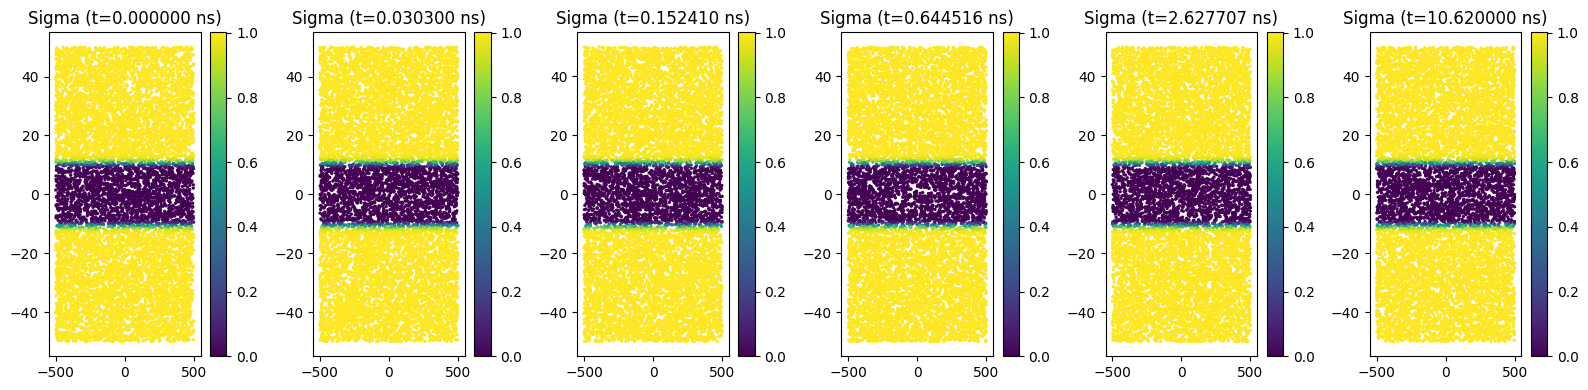

Text(0, 0.5, 'sigma values')

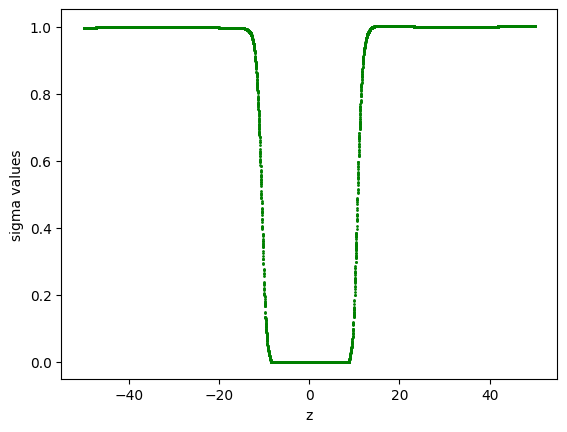

In [7]:
if flag_train_sigma == False:
    sigma_model.load_state_dict(torch.load("sigma_model_plane3D.pth"))
sigma_model.eval()

sampled_times = np.linspace(Norm_time(t_min), Norm_time(t_max), 6)
sampled_y = Norm_y( (y_max + y_min) / 2 )

n_samples = 10000
if flag_train_sigma == True:
    plt.figure(figsize=(16,10))
else:
    plt.figure(figsize=(16,4))

for i_plot, n_t in enumerate(sampled_times, 1):
    real_t = Inv_Norm_time(n_t)
    X_pred, sigma_true = generate_sigma_coords(n_samples)
    X_pred[:,0] = n_t * torch.ones_like( X_pred[:,0], device=device )
    X_pred[:,2] = sampled_y * torch.ones_like( X_pred[:,2], device=device )
    X = X_pred.detach().cpu().numpy()
    
    # predicted result
    with torch.no_grad():
        sigma_pred = sigma_model.forward(X_pred)
    sigma_pred = sigma_pred.detach().cpu().numpy()

    if flag_train_sigma == True:
        # true result
        sigma_true = sigma_true.detach().cpu().numpy()
        
        plt.subplot(3, len(sampled_times), i_plot)
        plt.title(f"Pred {real_t:3f} ns")
        im0=plt.scatter(Inv_Norm_x(X[:, 1]), Inv_Norm_z(X[:, 3]), c=sigma_pred, s=2)
        plt.colorbar(im0)
        
        plt.subplot(3, len(sampled_times), len(sampled_times) + i_plot)
        plt.title(f"True {real_t:3f} ns")
        im1=plt.scatter(Inv_Norm_x(X[:, 1]), Inv_Norm_z(X[:, 3]), c=sigma_true, s=2)
        plt.colorbar(im1)
    
        plt.subplot(3, len(sampled_times), 2*len(sampled_times) + i_plot)
        plt.title(f"Error {real_t:3f} ns")
        im2=plt.scatter(Inv_Norm_x(X[:, 1]), Inv_Norm_z(X[:, 3]), c=np.abs(sigma_true-sigma_pred), s=2)
        plt.colorbar(im2)
        
    else:
        plt.subplot(1, len(sampled_times), i_plot)
        plt.title(f"Sigma (t={real_t:3f} ns)")
        im0=plt.scatter(Inv_Norm_x(X[:, 1]), Inv_Norm_z(X[:, 3]), c=sigma_pred, s=2)
        plt.colorbar(im0)

plt.tight_layout()
plt.savefig("plot_c_sigma.jpg", format="jpg", dpi=300)
plt.show()


sigma_model.eval()
n_points = 10000
t_coords = norm_t_min * torch.ones(n_points, 1, device=device)
x_coords = norm_x_min * torch.ones(n_points, 1, device=device)
y_coords = norm_y_min * torch.ones(n_points, 1, device=device)
z_coords = norm_z_min + (norm_z_max - norm_z_min) * torch.rand(n_points, 1, device=device)
coords_sample = torch.cat( [t_coords, x_coords, y_coords, z_coords], dim=-1 )
sigma_sample  = sigma_model( coords_sample )
z_coords = z_coords.detach().cpu().numpy()
sigma_sample = sigma_sample.detach().cpu().numpy()
plt.scatter( Inv_Norm_z(z_coords), sigma_sample, c="green", s=1 )
plt.xlabel("z")
plt.ylabel("sigma values")
#plt.savefig("plot_c3D_sigma2.jpg", format="jpg", dpi=300)

<h1>PINN</h1>

<h3>Initial conditions</h3>

initial time : [-9.313226e-10]


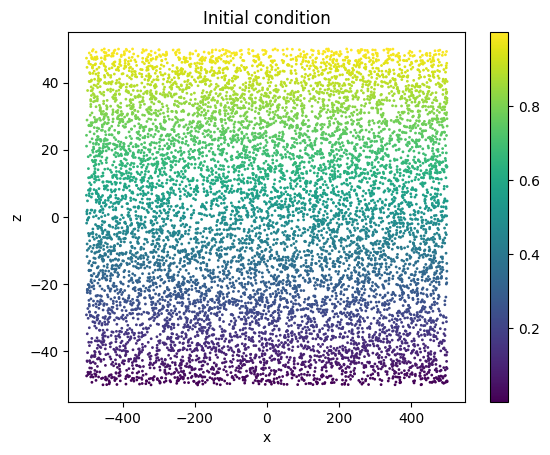

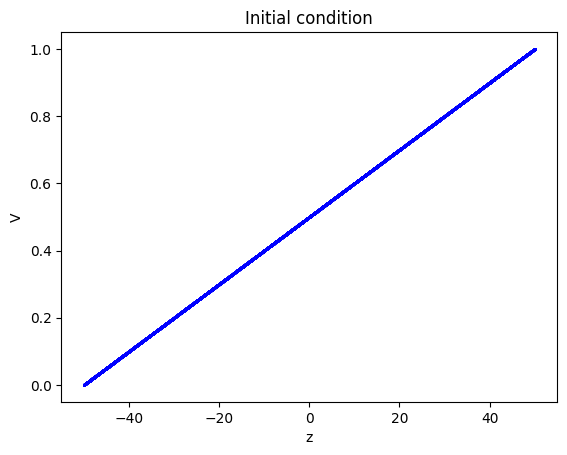

In [8]:
sigma_model.eval()

def gen_IC_points(model=None, batch_size=IC_batch_size, oversample_factor=4):
    # Oversample
    M = batch_size * oversample_factor
    t_coords = norm_t_min * torch.ones(M, 1, device=device)  # initial time
    x_coords = norm_x_min + (norm_x_max - norm_x_min) * torch.rand(M, 1, device=device)
    y_coords = norm_y_min + (norm_y_max - norm_y_min) * torch.rand(M, 1, device=device)
    z_coords = norm_z_min + (norm_z_max - norm_z_min) * torch.rand(M, 1, device=device)
    coords = torch.cat([t_coords, x_coords, y_coords, z_coords], dim=-1)
    z_factor = (z_coords - norm_z_min) / (norm_z_max - norm_z_min)
    V_target = V0 * z_factor
    # Importance sampling if model is not None
    if model is not None:
        coords.requires_grad=True
        V_pred = model(coords)
        grads = torch.autograd.grad(
            V_pred, coords,
            grad_outputs=torch.ones_like(V_pred),
            create_graph=False, retain_graph=False
        )[0]
        E_pred = ( (grads[:,1].unsqueeze(-1)/factor_x)**2 \
                + (grads[:,2].unsqueeze(-1)/factor_y)**2 \
                + (grads[:,3].unsqueeze(-1)/factor_z)**2 ) ** (1/2)
        weights = torch.abs(V_pred - V_target) + 10*torch.abs(E_pred - E0*torch.ones_like(E_pred)) + 1
        weights = torch.clamp(weights.squeeze(-1), min=1e-12)
        probs = weights / torch.sum(weights)
        # Resampling
        idx = torch.multinomial(probs, batch_size, replacement=False)
        coords_batch = coords[idx]
        values_batch = V_target[idx]
    else:
        # uniform sampling if model is None
        coords_batch = coords[:batch_size]
        values_batch = V_target[:batch_size]
    #
    return coords_batch.detach(), values_batch.detach()


def compute_IC_loss(model, n_points=IC_batch_size, loss_function=nn.MSELoss()):
    coords, values = gen_IC_points(model=model, batch_size=n_points)
    coords.requires_grad = True
    # IC loss wrt V
    values_pred = model.forward(coords)
    loss = loss_function( values_pred, values )
    # IC loss wrt E
    E_pred = ( (model._PDE.get_derivative(values_pred, coords, 1)[:,1].unsqueeze(-1)/factor_x)**2 \
                + (model._PDE.get_derivative(values_pred, coords, 1)[:,2].unsqueeze(-1)/factor_y)**2 \
                + (model._PDE.get_derivative(values_pred, coords, 1)[:,3].unsqueeze(-1)/factor_z)**2 ) ** (1/2)
    E_true = E0 * torch.ones_like(E_pred, device=device)
    loss += 1e4 * loss_function(E_pred, E_true)
    return loss
    

# PLOTs
points, IC_values = gen_IC_points(batch_size=10000)
print(f"initial time : {Inv_Norm_time(np.unique(points[:len(points)//2,0].detach().cpu().numpy()))}")
# plane XZ
x_coords = Inv_Norm_x( points[:,1] )
z_coords = Inv_Norm_z( points[:,3] )
x_coords = x_coords.detach().cpu().numpy()
z_coords = z_coords.detach().cpu().numpy()
IC_values = IC_values.detach().cpu().numpy()
# plots
fig = plt.scatter(x_coords, z_coords, c=IC_values, s=1)
plt.title("Initial condition")
plt.xlabel("x")
plt.ylabel("z")
plt.colorbar(fig)
plt.show()

fig = plt.scatter(z_coords, IC_values, s=1, c="blue")
plt.title("Initial condition")
plt.xlabel("z")
plt.ylabel("V")
plt.show()


<h3>Boundary condition</h3>

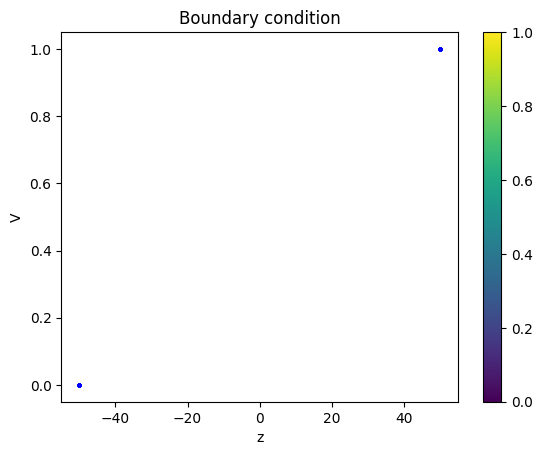

In [9]:
def gen_BC_points(n_points=BC_batch_size):
    # minimum z-coord
    t_coords = norm_t_min + (norm_t_max - norm_t_min) * torch.rand(n_points, 1, device=device)
    x_coords = norm_x_min + (norm_x_max - norm_x_min) * torch.rand(n_points, 1, device=device)
    y_coords = norm_y_min + (norm_y_max - norm_y_min) * torch.rand(n_points, 1, device=device)
    z_coords = norm_z_min * torch.ones(n_points, 1, device=device)       
    points2 = torch.cat( [t_coords, x_coords, y_coords, z_coords], dim=-1 )
    values2 = 0 * torch.ones_like( t_coords, device=device )
    # maximum z-coord
    t_coords = norm_t_min + (norm_t_max - norm_t_min) * torch.rand(n_points, 1, device=device)
    x_coords = norm_x_min + (norm_x_max - norm_x_min) * torch.rand(n_points, 1, device=device)
    y_coords = norm_y_min + (norm_y_max - norm_y_min) * torch.rand(n_points, 1, device=device)
    z_coords = norm_z_max * torch.ones(n_points, 1, device=device)       
    points3 = torch.cat( [t_coords, x_coords, y_coords, z_coords], dim=-1 )
    values3 = V0 * torch.ones_like( t_coords, device=device )
    #
    return torch.cat( [points2, points3], dim=0 ), torch.cat( [values2, values3], dim=0 )

def compute_BC_loss(model, n_points=BC_batch_size, loss_function=nn.MSELoss()):
    coords, values = gen_BC_points(n_points)
    coords.requires_grad = True
    values_pred = model.forward(coords)
    loss = loss_function( values_pred, values )
    return loss
    

# PLOT BC
points, BC_values = gen_BC_points(10000)
z_coords = Inv_Norm_z( points[:,3] )
z_coords = z_coords.detach().cpu().numpy()
BC_values = BC_values.detach().cpu().numpy()
fig = plt.scatter(z_coords, BC_values, s=3, c="blue")
plt.title("Boundary condition")
plt.xlabel("z")
plt.ylabel("V")
plt.colorbar(fig)
plt.show()

<h3>PDE</h3>

In [10]:
eps1 = epsilon * 1e8
sig1 = _sigma * 1e8

class QSM_PDE:
       
    def compute_PDE(self, coords, pred_func, flag=False):
        sigma_model.eval()
        sigma_comp = sigma_model.forward(coords)
        u = pred_func[:,0].unsqueeze(-1)
        u_x  = self.get_derivative(pred_func, coords, 1)[:,1].unsqueeze(-1) / factor_x
        u_xx = self.get_derivative(u_x, coords, 1)[:,1].unsqueeze(-1) / factor_x
        u_y  = self.get_derivative(pred_func, coords, 1)[:,2].unsqueeze(-1) / factor_y
        u_yy = self.get_derivative(u_y, coords, 1)[:,2].unsqueeze(-1) / factor_y
        u_z  = self.get_derivative(pred_func, coords, 1)[:,3].unsqueeze(-1) / factor_z
        u_zz = self.get_derivative(u_z, coords, 1)[:,3].unsqueeze(-1) / factor_z
        Delta_u = u_xx + u_yy + u_zz
        Delta_u_t = self.get_derivative(Delta_u, coords, 1)[:,0].unsqueeze(-1)
        div_sigma_grad_u =  self.get_derivative(sigma_comp, coords, 1)[:,1].unsqueeze(-1) * u_x / factor_x \
                                + sigma_comp * self.get_derivative(u_x, coords, 1)[:,1].unsqueeze(-1) / factor_x \
                          + self.get_derivative(sigma_comp, coords, 1)[:,2].unsqueeze(-1) * u_y / factor_y \
                                + sigma_comp * self.get_derivative(u_y, coords, 1)[:,2].unsqueeze(-1) / factor_y \
                          + self.get_derivative(sigma_comp, coords, 1)[:,3].unsqueeze(-1) * u_z / factor_z \
                                + sigma_comp * self.get_derivative(u_z, coords, 1)[:,3].unsqueeze(-1) / factor_z
        # equation
        factorrr = torch.exp(coords[:,0].unsqueeze(-1) * factor_logt) * factor_logt
        P1 = Delta_u_t / factorrr * eps1
        P2 = div_sigma_grad_u * sig1
        eq = P1 + P2
        if flag == True:
            # se è True stampo ogni parte della pde
            u_t = self.get_derivative(u, coords, 1)[:,0] / factorrr
            print(f"u_t in [{(u_t).min()}, {(u_t).max()}] , mean = {torch.mean((u_t))}")
            print(f"Eps in [{(P1).min()}, {(P1).max()}] , mean = {torch.mean((P1))}")
            print(f"Div in [{(P2).min()}, {(P2).max()}] , mean = {torch.mean((P2))}")
            print(f"Eq  in [{(eq).min()}, {(eq).max()}] , mean = {torch.mean((eq))}")
            print(" ")
        return eq.squeeze(-1)*1e3, P1.squeeze(-1)*1e3, P2.squeeze(-1)*1e3

        
    def gen_PDE_points(self, model, batch_size=PDE_batch_size, oversample_factor=5):
        # Oversample
        M = batch_size * oversample_factor
        t_coords = norm_t_min + (norm_t_max - norm_t_min) * torch.rand(M, 1, device=device)
        x_coords = norm_x_min + (norm_x_max - norm_x_min) * torch.rand(M, 1, device=device)
        y_coords = norm_y_min + (norm_y_max - norm_y_min) * torch.rand(M, 1, device=device)
        z_coords = norm_z_min + (norm_z_max - norm_z_min) * torch.rand(M, 1, device=device)
        coords = torch.cat([t_coords, x_coords, y_coords, z_coords], dim=-1)
        coords.requires_grad=True
        V_pred = model(coords)
        grads = torch.autograd.grad(
            V_pred, coords,
            grad_outputs=torch.ones_like(V_pred),
            create_graph=False, retain_graph=False
        )[0]
        dV_dt = grads[:, 0:1]
        dV_dx = grads[:, 1:]
        grad_norm = torch.norm(dV_dx, dim=1, keepdim=True)
        # Importance sampling
        weights = ( grad_norm**2 + 5 * dV_dt**2 ) ** 0.5 + torch.abs( V_pred ) + 10
        weights = weights.squeeze(-1)
        weights = torch.clamp(weights, min=1e-12)  # evitare zero
        probs = weights / torch.sum(weights)
        # Resampling
        idx = torch.multinomial(probs, batch_size, replacement=False)
        coords_batch = coords[idx]
        return coords_batch.detach()

    
    def get_derivative(self, y, x, n: int = 1):
        if n == 0:
            return y
        else:
            dy_dx = torch.autograd.grad(y, x, torch.ones_like(y).to(y.device), create_graph=True, retain_graph=True, allow_unused=True)[0]              
        return self.get_derivative(dy_dx, x, n - 1)


    def compute_PDE_loss(self, model, n_points=PDE_batch_size, loss_function=nn.MSELoss(), flag=False):
        coords = self.gen_PDE_points(model=model, batch_size=n_points)
        coords.requires_grad = True
        values_pred = model.forward(coords)
        pde_pred, _, _ = self.compute_PDE(coords, values_pred, flag=flag)
        loss = loss_function( pde_pred, torch.zeros_like(pde_pred, dtype=torch.float32, device=device) )
        return loss

<h3>PINN model</h3>

In [13]:
class SelfScaledTanh(nn.Module):
    def __init__(self, size, init_beta=0.0):
        super().__init__()
        self.beta = nn.Parameter(torch.full((size,), init_beta, dtype=torch.float32))

    def forward(self, x):
        return torch.tanh(x) + self.beta * x * torch.tanh(x)
    

class PINN_model(nn.Module):
    def __init__(self, input_dim, n_nodes, n_layers, n_batches, dropout):
        super().__init__()
        self.n_batches = n_batches
        self.dropout = dropout
        validation_split = 0.1
        self.n_train_batches = int((1 - validation_split) * self.n_batches)
        self.n_val_batches = self.n_batches - self.n_train_batches
        self.n_layers = n_layers
        self.n_nodes = n_nodes
        self.history = []
        self.optimizer = 0
        self.total_time = 0
        self._PDE = QSM_PDE()
        # ==== LAYERS ====
        self.input_layer = nn.Linear(input_dim, n_nodes)
        self.initial_activation = SelfScaledTanh(n_nodes)
        self.hidden_layers = nn.ModuleList()
        for _ in range(n_layers - 1):
            self.hidden_layers.append(
                nn.Sequential(
                    nn.Linear(n_nodes, n_nodes),
                    SelfScaledTanh(n_nodes),
                    nn.Dropout(self.dropout)
                )
            )

        self.output_layer = nn.Linear(n_nodes, 1)
        self.final_activation = SelfScaledTanh(1)

    
    def forward(self, coords):
        x = self.initial_activation(self.input_layer(coords))
        residual = x
        for i, layer in enumerate(self.hidden_layers):
            out = layer(x)
            if i % 2 == 1:
                x = out + residual
                residual = x
            else:
                x = out
        x = self.output_layer(x)
        return self.final_activation(x)
        
    
    def train_model(
        self, 
        optimizer, 
        patience = 20, 
        factor_scheduler = 0.98, 
        loss_function = nn.MSELoss(), 
        epochs = 2000, 
        flag_plot_PDE = 20, 
        flag_plot = 100,
        flag_losses = 1,
        flag_checkpoint = 500
    ):
        print("Start :")
        start_time = time.time()   
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.98, patience=patience)
        self.history = []
        self.optimizer = optimizer
        # number of batches for training and validation
        print(f"  number of epochs             : {epochs}")
        print(f"  number of train batches      : {self.n_train_batches}")
        print(f"  number of validation batches : {self.n_val_batches}")
        print(" ")        
        print("Training in progress...")
        print(" ")
        n_train_batches = self.n_train_batches
        n_val_batches = self.n_val_batches

        weight_IC, weight_BC, weight_PDE = 1, 1, 1e-1

        for epoch in range(epochs):
            start = time.time()
            
            # === TRAINING STEP ===
            self.train()
            start_tr = time.time()
            IC_total_loss, BC_total_loss, PDE_total_loss = 0, 0, 0            
            for indx_batch in range(n_train_batches):
                optimizer.zero_grad()
                IC_loss  = compute_IC_loss(model=self)
                BC_loss  = compute_BC_loss(model=self)
                if epoch % 50 == 0 and indx_batch == n_train_batches - 1:
                    # ogni 50 epoche stampo gli errori di ogni parte della pde
                    PDE_loss = self._PDE.compute_PDE_loss(model=self, flag=True )
                else:
                    PDE_loss = self._PDE.compute_PDE_loss(model=self, flag=False)
                Loss = weight_IC * IC_loss + weight_BC * BC_loss + weight_PDE * PDE_loss
                Loss.backward()
                optimizer.step()
                IC_total_loss   += IC_loss.item()
                BC_total_loss   += BC_loss.item()
                PDE_total_loss  += PDE_loss.item()
            IC_total_loss  /= n_train_batches
            BC_total_loss  /= n_train_batches
            PDE_total_loss /= n_train_batches
            end_tr = time.time()

            # === VALIDATION STEP ===
            self.eval()
            start_val = time.time()
            IC_val_loss, BC_val_loss, PDE_val_loss = 0, 0, 0  
            for indx_batch in range(n_val_batches):
                optimizer.zero_grad()
                IC_val_loss  += (compute_IC_loss(model=self) ).item()
                BC_val_loss  += ( compute_BC_loss(model=self) ).item()
                PDE_val_loss += ( self._PDE.compute_PDE_loss(model=self) ).item()
            IC_val_loss   /= n_val_batches
            BC_val_loss   /= n_val_batches
            PDE_val_loss  /= n_val_batches
            scheduler.step( weight_IC * IC_val_loss + weight_BC * BC_val_loss + weight_PDE * PDE_val_loss )
            end_val = time.time()
            
            end = time.time()

            
            lambda_eff = weight_PDE/weight_IC * PDE_total_loss/IC_total_loss
            current_lr = self.optimizer.param_groups[0]['lr']
            if (epoch+1) % 500 == 0:
                # === PRINT LOSSES ===
                print(f"Epoch {epoch+1}/{epochs}")
                print(f"  Training losses   ==>  IC: {IC_total_loss} - BC: {BC_total_loss} - pde: {PDE_total_loss}")
                print(f"  Validation losses ==>  IC: {IC_val_loss} - BC: {BC_val_loss} - pde: {PDE_val_loss}")
                print(f"  time : {end - start} s  - train: {end_tr - start_tr} s  - val: {end_val - start_val} s")
                print(f"     ( w_IC : {weight_IC} - w_BC : {weight_BC} - w_PDE : {weight_PDE} - lambda_eff : {lambda_eff} )")
                print(f"     ( learning rate : {current_lr})")
                print(f" ")
                print(f" ")
            self.history.append([ IC_total_loss, PDE_total_loss, IC_val_loss, PDE_val_loss,
                            weight_IC, weight_PDE, lambda_eff, current_lr, BC_total_loss, BC_val_loss, weight_BC, 0 ])



            # PLOT
            if epoch % flag_plot == 0:
                
                sampled_times = Norm_time( t_min + np.array([ 0, 0.1, 0.2, 0.3, 0.7, 1 ]) * (t_max - t_min) )
                n_samples = 20000
                plt.figure(figsize=(16,14))
                for i_plot, n_t in enumerate(sampled_times, 1):
                    real_t = Inv_Norm_time(n_t)
                    X_pred = self._PDE.gen_PDE_points(self, batch_size=n_samples)
                    X_pred[:,0] = n_t * torch.ones_like(X_pred[:,0], device=device)
                    X_Sample = X_pred.detach().cpu().numpy()
                    X_pred.requires_grad=True
                    V_pred = self.forward(X_pred)
                    
                    E_pred = ( (self._PDE.get_derivative(V_pred, X_pred, 1)[:,1].unsqueeze(-1)/factor_x)**2 \
                            + (self._PDE.get_derivative(V_pred, X_pred, 1)[:,2].unsqueeze(-1)/factor_y)**2 \
                            + (self._PDE.get_derivative(V_pred, X_pred, 1)[:,3].unsqueeze(-1)/factor_z)**2 ) ** (1/2)
                    V_pred = V_pred.detach().cpu().numpy()
                    E_pred = E_pred.detach().cpu().numpy()

                    v_min = 0
                    v_max = V0
                    
                    # ====== VOLT ======
                    plt.subplot(4, len(sampled_times), i_plot)
                    im0=plt.scatter(Inv_Norm_x(X_Sample[:, 1]), Inv_Norm_z(X_Sample[:, 3]), c=V_pred, s=2, cmap='plasma', vmin=v_min, vmax=v_max)
                    # linea rossa condensatore piastre
                    x_vals = x_min + (x_max - x_min) * np.random.rand(1000)
                    z_val  = z_max - L/2 + d/2
                    plt.scatter(x_vals, np.full_like(x_vals, z_val), c="red", s=1)
                    z_val  = z_min+L/2 - d/2
                    plt.scatter(x_vals, np.full_like(x_vals, z_val), c="red", s=1)
                    plt.title(f"V(t={real_t:.2f} ns)")
                    plt.xlabel("x coordinate [$\\mu$m]")
                    if i_plot == 1:
                        plt.ylabel("z coordinate [$\\mu$m]")
                    plt.xlim(x_min, x_max)
                    plt.ylim(z_min, z_max)
                    plt.colorbar(im0)
                    plt.tight_layout()
                    
                    # ====== VOLT UNIDIM ======
                    plt.subplot(4, len(sampled_times), len(sampled_times) + i_plot)
                    im2=plt.scatter(Inv_Norm_z(X_Sample[:, 3]), V_pred, s=1)
                    plt.title(f"t = {real_t:.2f} ns")
                    if i_plot == 1:
                        plt.ylabel("Potential [V]")
                    plt.xlabel("z coordinate [$\\mu$m]")
                    plt.tight_layout()

                    # ====== ELECTRIC ======
                    v_min = 0
                    v_max = (V0 - 0) / ( norm_z_max - norm_z_min ) / factor_z
                    plt.subplot(4, len(sampled_times), 2*len(sampled_times) + i_plot)
                    im1=plt.scatter(Inv_Norm_x(X_Sample[:, 1]), Inv_Norm_z(X_Sample[:, 3]), c=E_pred, s=2, cmap='plasma', vmin=0, vmax=0.05)
                    # linea rossa condensatore piastre
                    x_vals = x_min + (x_max - x_min) * np.random.rand(1000)
                    z_val  = z_max - L/2 + d/2
                    plt.scatter(x_vals, np.full_like(x_vals, z_val), c="red", s=1)
                    z_val  = z_min + L/2 - d/2
                    plt.scatter(x_vals, np.full_like(x_vals, z_val), c="red", s=1)
                    plt.title(f"E(t={real_t:.2f} ns)")
                    plt.xlabel("x coordinate [$\\mu$m]")
                    if i_plot == 1:
                        plt.ylabel("z coordinate [$\\mu$m]")
                    plt.xlim(x_min, x_max)
                    plt.ylim(z_min, z_max)
                    plt.colorbar(im1)
                    plt.tight_layout()

                    # ====== ELECTRIC UNIDIM ======
                    plt.subplot(4, len(sampled_times), 3*len(sampled_times) + i_plot)
                    im3=plt.scatter(Inv_Norm_z(X_Sample[:, 3]), E_pred, s=1)
                    plt.ylim(0,0.06)
                    plt.title(f"t = {real_t:.2f} ns")
                    if i_plot == 1:
                        plt.ylabel("Electric field [V/$\\mu$m]")
                    plt.xlabel("z coordinate [$\\mu$m]")
                    plt.tight_layout()
                namee = f"plot_c_pred_temp_{epoch}.jpg"
                plt.savefig(namee, format="jpg", dpi=300)
                plt.show()

            # === CHECKPOINT ===
            if (epoch) % flag_checkpoint == 0 and epoch>0:
                checkpoint_path = f"checkpoint_c_epoch_{epoch}.pth"
                torch.save({
                    'n_nodes': self.n_nodes,
                    'n_layers': self.n_layers,
                    'epoch': epoch + 1,
                    'model_state_dict': self.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'history': self.history
                }, checkpoint_path)

        # END EPOCHS
        self.history = torch.stack([torch.tensor(h) for h in self.history]).detach().cpu().numpy()
        print(f"Done!  (time : {time.time() - start_time})")
        return self.history


<h3>Training</h3>

Start :
  number of epochs             : 10000
  number of train batches      : 28
  number of validation batches : 4
 
Training in progress...
 
u_t in [0.0017750997794792056, 7.3524169921875] , mean = 0.6917425990104675
Eps in [-0.0009553405689075589, 7.722196460235864e-05] , mean = -7.591585017507896e-05
Div in [-0.00787083338946104, 0.006920756306499243] , mean = -2.5648032533354126e-05
Eq  in [-0.008141923695802689, 0.00632217712700367] , mean = -0.00010156388452742249
 


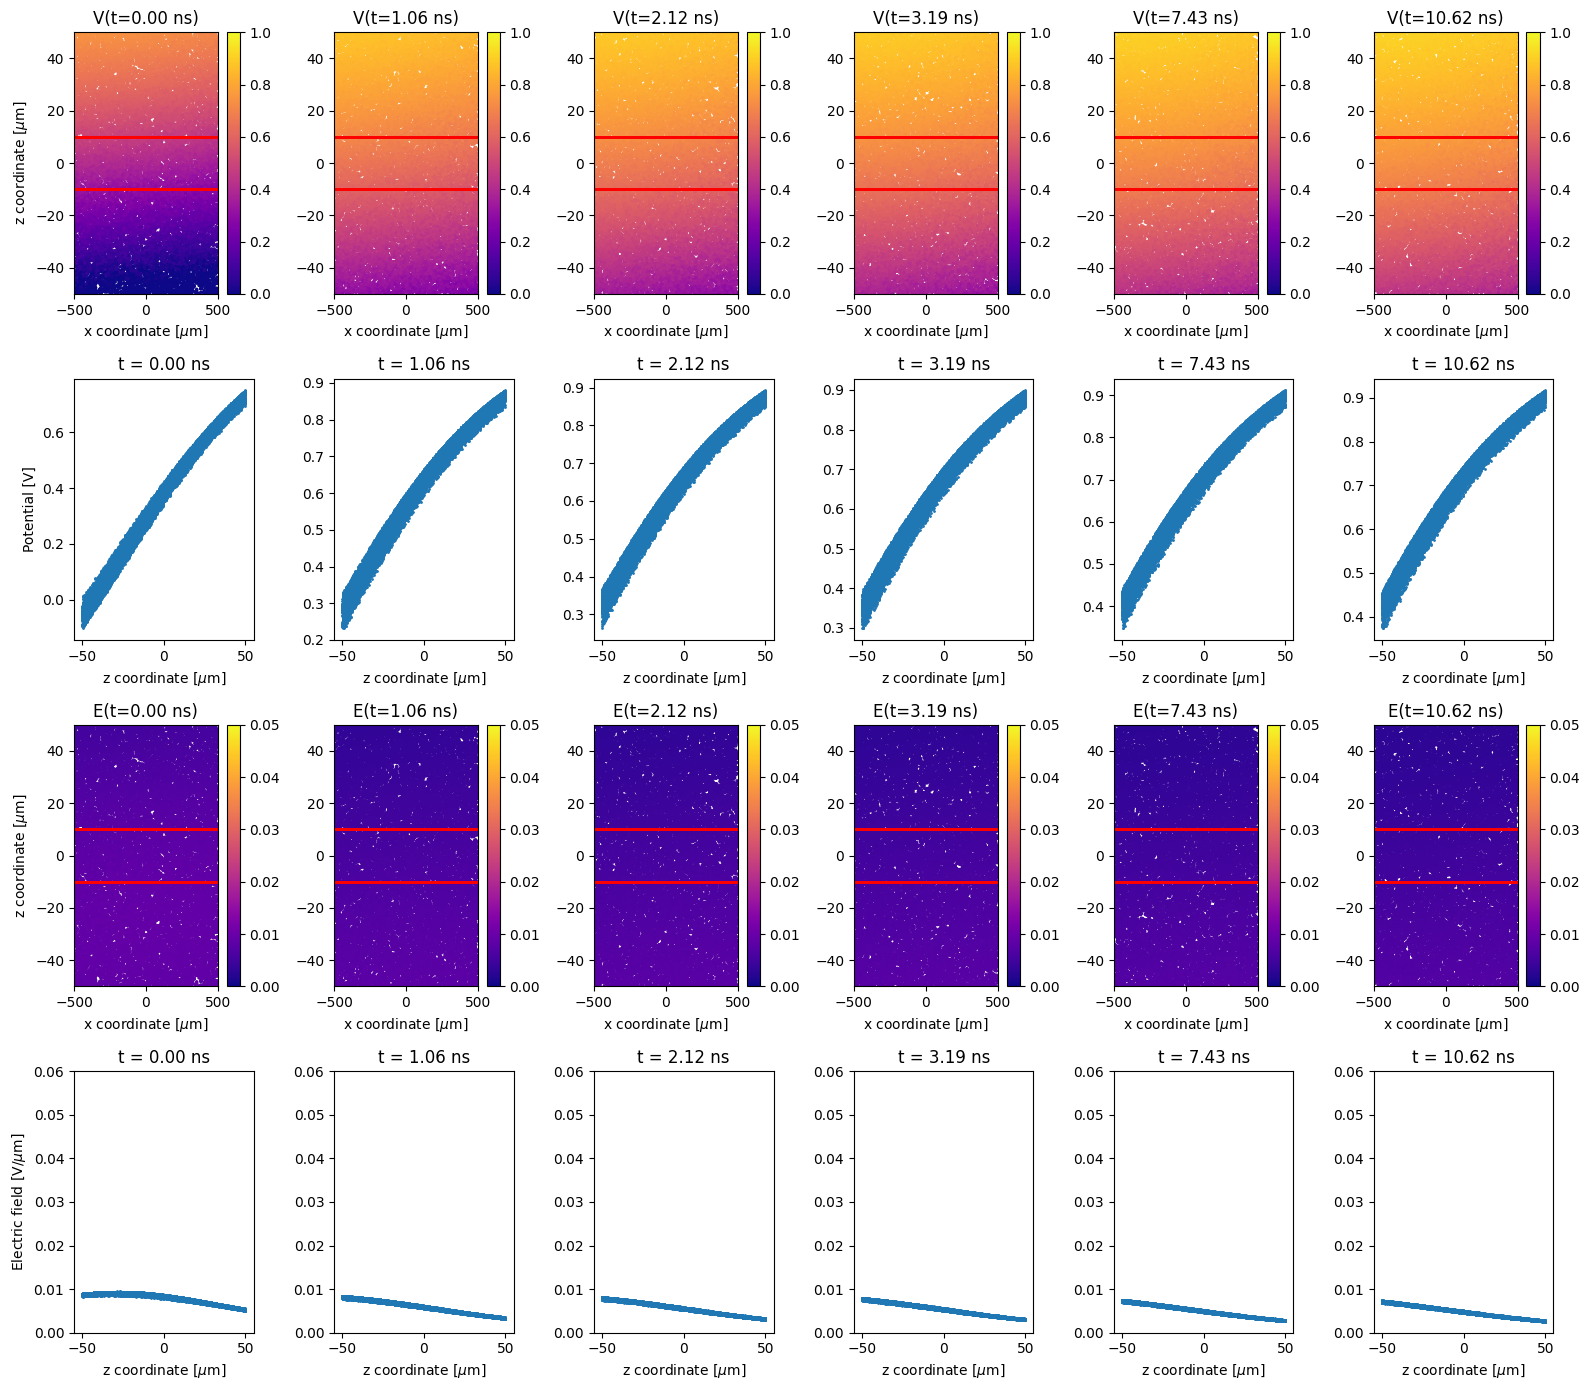

KeyboardInterrupt: 

In [14]:
### construction of PINN
model = 0
model = PINN_model( 
    input_dim = 4,  # (t, x, y, z)
    n_nodes = 128, 
    n_layers = 6,
    n_batches = 32,
    dropout = 0 
).to(device)

# training
optimizer = torch.optim.Adam(model.parameters(), lr=0.003, weight_decay=1e-9)
loss_function = nn.MSELoss()
model.train_model(
    optimizer, 
    patience = 20, 
    factor_scheduler = 0.98,
    loss_function = loss_function, 
    epochs = 10000,
    flag_plot_PDE = 500, 
    flag_plot = 500,
    flag_losses = 500,
    flag_checkpoint = 1000
)

In [ ]:
checkpoint_path = f"model-c3D.pth"
torch.save({
    'n_nodes': model.n_nodes,
    'n_layers': model.n_layers,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': model.optimizer.state_dict(),
    'history': model.history
}, checkpoint_path)

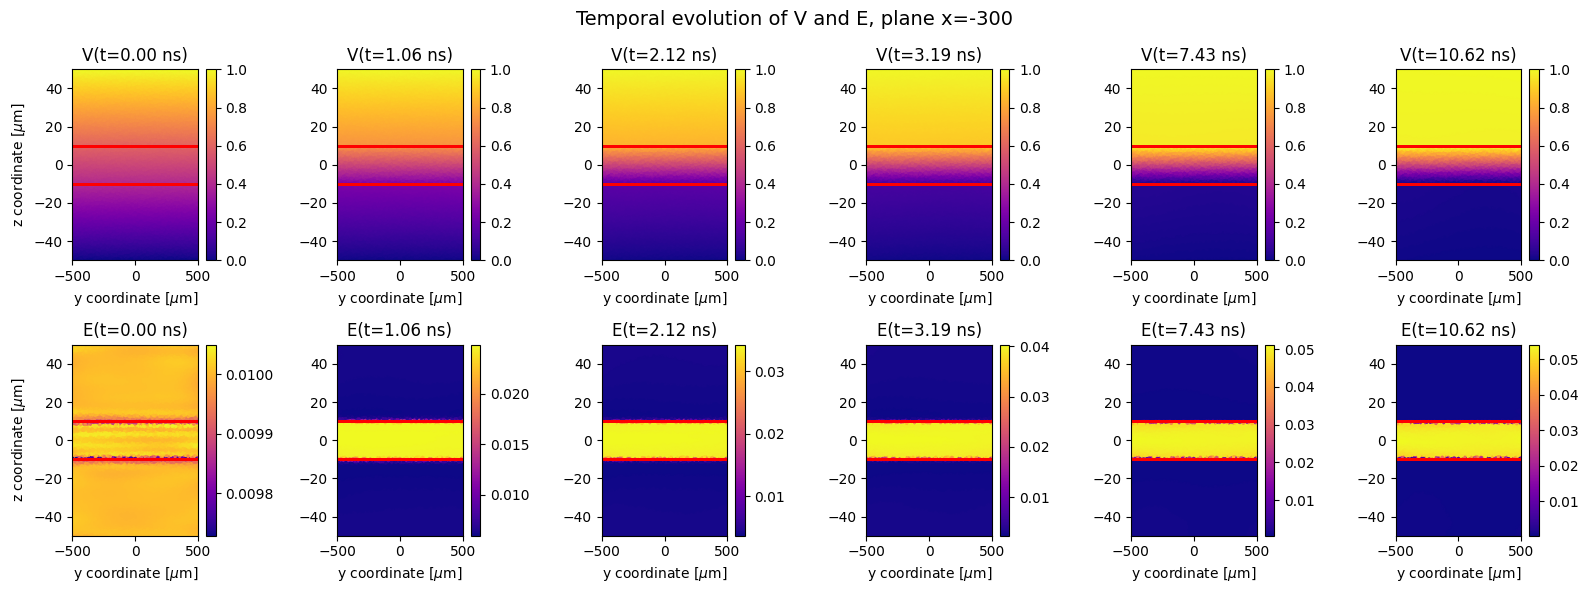

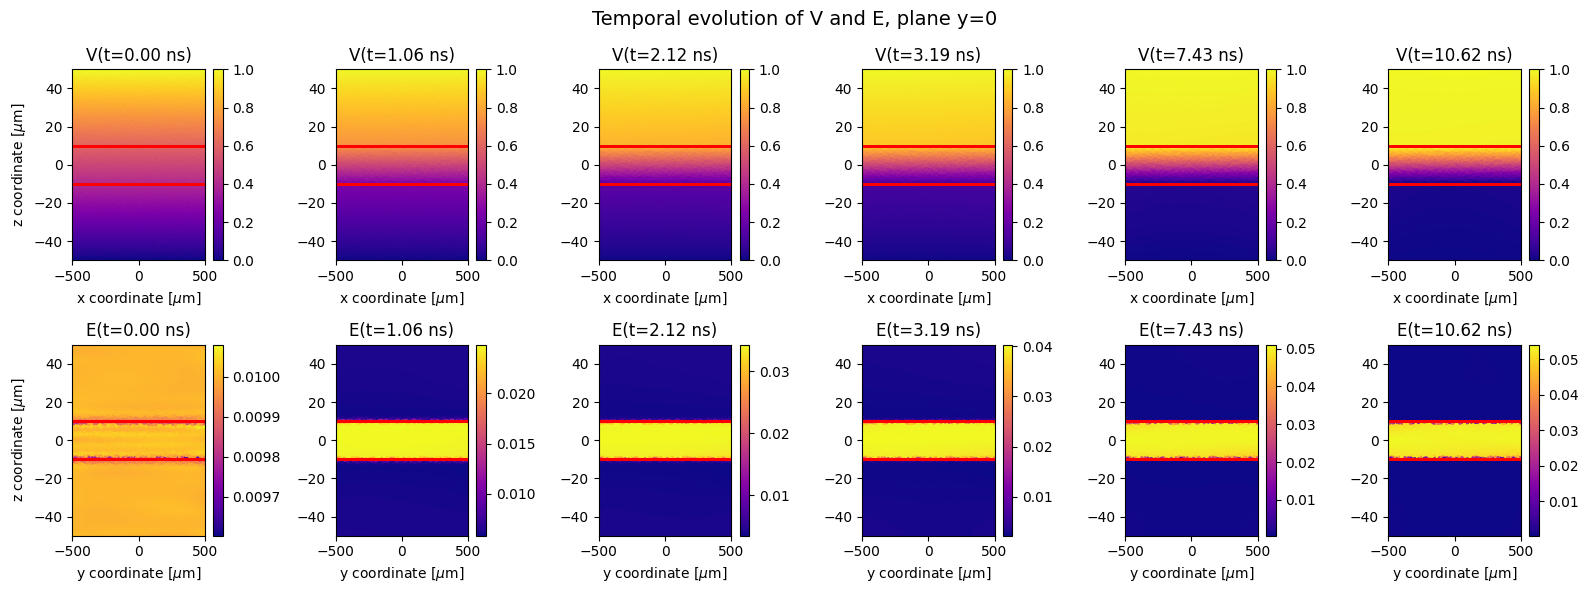

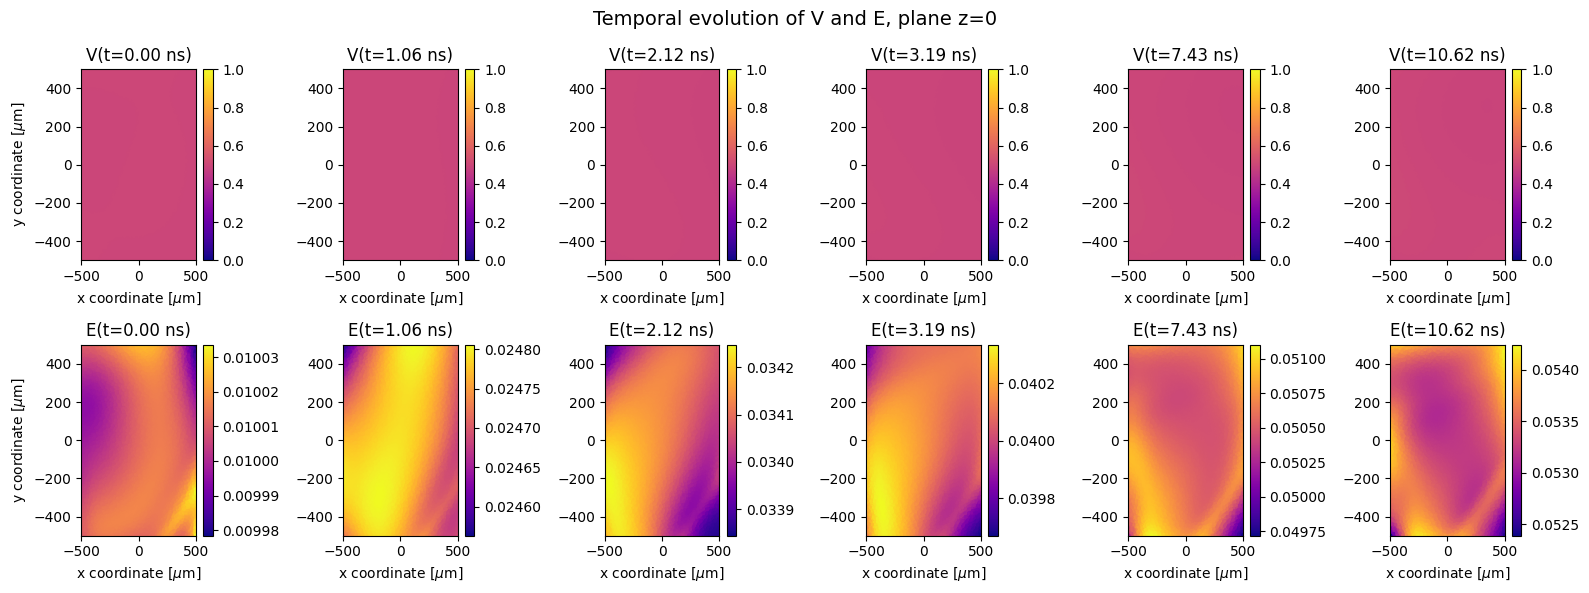

In [16]:
input_dim = 4     # (t, x, y, z)
n_nodes = 128
n_layers = 6
n_batches = 32
dropout = 0
model = PINN_model( input_dim, n_nodes, n_layers, n_batches, dropout ).to(device)
checkpoint = torch.load("model-c3D.pth", map_location=device, weights_only=False)
model.load_state_dict(checkpoint["model_state_dict"])

sampled_times = Norm_time( t_min + np.array([ 0, 0.1, 0.2, 0.3, 0.7, 1 ]) * (t_max - t_min) )
n_samples = 100000
model.eval()
sigma_model.eval()
pde_class = QSM_PDE()

x_coords = norm_x_min + (norm_x_max - norm_x_min) * torch.rand(n_samples, 1, device=device)
y_coords = norm_y_min + (norm_y_max - norm_y_min) * torch.rand(n_samples, 1, device=device)
z_coords = norm_z_min + (norm_z_max - norm_z_min) * torch.rand(n_samples, 1, device=device)

n_plot = 2
v_min = 0
v_max = V0

plt.figure(figsize=(16,6))
# --- plane x=-300 ---
for i_plot, n_t in enumerate(sampled_times, 1):
    real_t = Inv_Norm_time(n_t)
    X_pred = torch.cat([
        n_t * torch.ones_like(x_coords, device=device),
        Norm_x( -300 * torch.ones_like(x_coords, device=device) ),
        y_coords,
        z_coords
    ], dim=-1)
    X_Sample = X_pred.detach().cpu().numpy()
    X_pred.requires_grad=True
    V_pred = model.forward(X_pred)
    E_pred = ( (pde_class.get_derivative(V_pred, X_pred, 1)[:,1].unsqueeze(-1)/factor_x)**2 \
              + (pde_class.get_derivative(V_pred, X_pred, 1)[:,2].unsqueeze(-1)/factor_y)**2 \
              + (pde_class.get_derivative(V_pred, X_pred, 1)[:,3].unsqueeze(-1)/factor_z)**2 ) ** (1/2)
    V_pred = V_pred.detach().cpu().numpy()
    E_pred = E_pred.detach().cpu().numpy()
    # ====== V ======
    plt.subplot(n_plot, len(sampled_times), i_plot)
    im0=plt.scatter(Inv_Norm_y(X_Sample[:, 2]), Inv_Norm_z(X_Sample[:, 3]), c=V_pred, s=2, cmap='plasma', vmin=v_min, vmax=v_max)
    # linea rossa condensatore piastre
    x_vals = x_min + (x_max - x_min) * np.random.rand(1000)
    z_val  = z_max - L/2 + d/2
    plt.scatter(x_vals, np.full_like(x_vals, z_val), c="red", s=1)
    z_val  = z_min+L/2 - d/2
    plt.scatter(x_vals, np.full_like(x_vals, z_val), c="red", s=1)
    plt.title(f"V(t={real_t:.2f} ns)")
    plt.xlabel("y coordinate [$\\mu$m]")
    if i_plot == 1:
        plt.ylabel("z coordinate [$\\mu$m]")
    plt.xlim(y_min, y_max)
    plt.ylim(z_min, z_max)
    plt.colorbar(im0)
    plt.tight_layout()
    # ====== E ======
    plt.subplot(n_plot, len(sampled_times), len(sampled_times) + i_plot)
    im0=plt.scatter(Inv_Norm_y(X_Sample[:, 2]), Inv_Norm_z(X_Sample[:, 3]), c=E_pred, s=2, cmap='plasma')
    # linea rossa condensatore piastre
    x_vals = x_min + (x_max - x_min) * np.random.rand(1000)
    z_val  = z_max - L/2 + d/2
    plt.scatter(x_vals, np.full_like(x_vals, z_val), c="red", s=1)
    z_val  = z_min+L/2 - d/2
    plt.scatter(x_vals, np.full_like(x_vals, z_val), c="red", s=1)
    plt.title(f"E(t={real_t:.2f} ns)")
    plt.xlabel("y coordinate [$\\mu$m]")
    if i_plot == 1:
        plt.ylabel("z coordinate [$\\mu$m]")
    plt.xlim(y_min, y_max)
    plt.ylim(z_min, z_max)
    plt.colorbar(im0)
    plt.tight_layout()

plt.suptitle("Temporal evolution of V and E, plane x=-300", fontsize=14)
plt.tight_layout()
plt.savefig("plot_c_plane_x-300.jpg", format="jpg", dpi=300)
plt.show()




plt.figure(figsize=(16,6))
# --- plane y=0 ---
for i_plot, n_t in enumerate(sampled_times, 1):
    real_t = Inv_Norm_time(n_t)
    X_pred = torch.cat([
        n_t * torch.ones_like(x_coords, device=device),
        x_coords,
        Norm_y( 0 * torch.ones_like(x_coords, device=device) ),
        z_coords
    ], dim=-1)
    X_Sample = X_pred.detach().cpu().numpy()
    X_pred.requires_grad=True
    V_pred = model.forward(X_pred)
    E_pred = ( (pde_class.get_derivative(V_pred, X_pred, 1)[:,1].unsqueeze(-1)/factor_x)**2 \
              + (pde_class.get_derivative(V_pred, X_pred, 1)[:,2].unsqueeze(-1)/factor_y)**2 \
              + (pde_class.get_derivative(V_pred, X_pred, 1)[:,3].unsqueeze(-1)/factor_z)**2 ) ** (1/2)
    V_pred = V_pred.detach().cpu().numpy()
    E_pred = E_pred.detach().cpu().numpy()
    # ====== V ======
    plt.subplot(n_plot, len(sampled_times), i_plot)
    im0=plt.scatter(Inv_Norm_x(X_Sample[:, 1]), Inv_Norm_z(X_Sample[:, 3]), c=V_pred, s=2, cmap='plasma', vmin=v_min, vmax=v_max)
    plt.title(f"V(t={real_t:.2f} ns)")
    # linea rossa condensatore piastre
    x_vals = x_min + (x_max - x_min) * np.random.rand(1000)
    z_val  = z_max - L/2 + d/2
    plt.scatter(x_vals, np.full_like(x_vals, z_val), c="red", s=1)
    z_val  = z_min+L/2 - d/2
    plt.scatter(x_vals, np.full_like(x_vals, z_val), c="red", s=1)
    plt.xlabel("x coordinate [$\\mu$m]")
    if i_plot == 1:
        plt.ylabel("z coordinate [$\\mu$m]")
    plt.xlim(x_min, x_max)
    plt.ylim(z_min, z_max)
    plt.colorbar(im0)
    plt.tight_layout()
    # ====== E ======
    plt.subplot(n_plot, len(sampled_times), len(sampled_times) + i_plot)
    im0=plt.scatter(Inv_Norm_x(X_Sample[:, 1]), Inv_Norm_z(X_Sample[:, 3]), c=E_pred, s=2, cmap='plasma')
    plt.title(f"E(t={real_t:.2f} ns)")
    # linea rossa condensatore piastre
    x_vals = x_min + (x_max - x_min) * np.random.rand(1000)
    z_val  = z_max - L/2 + d/2
    plt.scatter(x_vals, np.full_like(x_vals, z_val), c="red", s=1)
    z_val  = z_min+L/2 - d/2
    plt.scatter(x_vals, np.full_like(x_vals, z_val), c="red", s=1)
    plt.xlabel("y coordinate [$\\mu$m]")
    if i_plot == 1:
        plt.ylabel("z coordinate [$\\mu$m]")
    plt.xlim(x_min, x_max)
    plt.ylim(z_min, z_max)
    plt.colorbar(im0)
    plt.tight_layout()

plt.suptitle("Temporal evolution of V and E, plane y=0", fontsize=14)
plt.tight_layout()
plt.savefig("plot_c_plane_y0.jpg", format="jpg", dpi=300)
plt.show()




plt.figure(figsize=(16,6))
# --- plane z=0 ---
for i_plot, n_t in enumerate(sampled_times, 1):
    real_t = Inv_Norm_time(n_t)
    X_pred = torch.cat([
        n_t * torch.ones_like(x_coords, device=device),
        x_coords,
        y_coords,
        Norm_z( 0 * torch.ones_like(x_coords, device=device) )
    ], dim=-1)
    X_Sample = X_pred.detach().cpu().numpy()
    X_pred.requires_grad=True
    V_pred = model.forward(X_pred)
    E_pred = ( (pde_class.get_derivative(V_pred, X_pred, 1)[:,1].unsqueeze(-1)/factor_x)**2 \
              + (pde_class.get_derivative(V_pred, X_pred, 1)[:,2].unsqueeze(-1)/factor_y)**2 \
              + (pde_class.get_derivative(V_pred, X_pred, 1)[:,3].unsqueeze(-1)/factor_z)**2 ) ** (1/2)
    V_pred = V_pred.detach().cpu().numpy()
    E_pred = E_pred.detach().cpu().numpy()
    # ====== V ======
    plt.subplot(n_plot, len(sampled_times), i_plot)
    im0=plt.scatter(Inv_Norm_x(X_Sample[:, 1]), Inv_Norm_y(X_Sample[:, 2]), c=V_pred, s=2, cmap='plasma', vmin=v_min, vmax=v_max)
    plt.title(f"V(t={real_t:.2f} ns)")
    plt.xlabel("x coordinate [$\\mu$m]")
    if i_plot == 1:
        plt.ylabel("y coordinate [$\\mu$m]")
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.colorbar(im0)
    plt.tight_layout()
    # ====== E ======
    plt.subplot(n_plot, len(sampled_times), len(sampled_times) + i_plot)
    im0=plt.scatter(Inv_Norm_x(X_Sample[:, 1]), Inv_Norm_y(X_Sample[:, 2]), c=E_pred, s=2, cmap='plasma')
    plt.title(f"E(t={real_t:.2f} ns)")
    plt.xlabel("x coordinate [$\\mu$m]")
    if i_plot == 1:
        plt.ylabel("y coordinate [$\\mu$m]")
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.colorbar(im0)
    plt.tight_layout()

plt.suptitle("Temporal evolution of V and E, plane z=0", fontsize=14)
plt.tight_layout()
plt.savefig("plot_c_plane_z0.jpg", format="jpg", dpi=300)
plt.show()

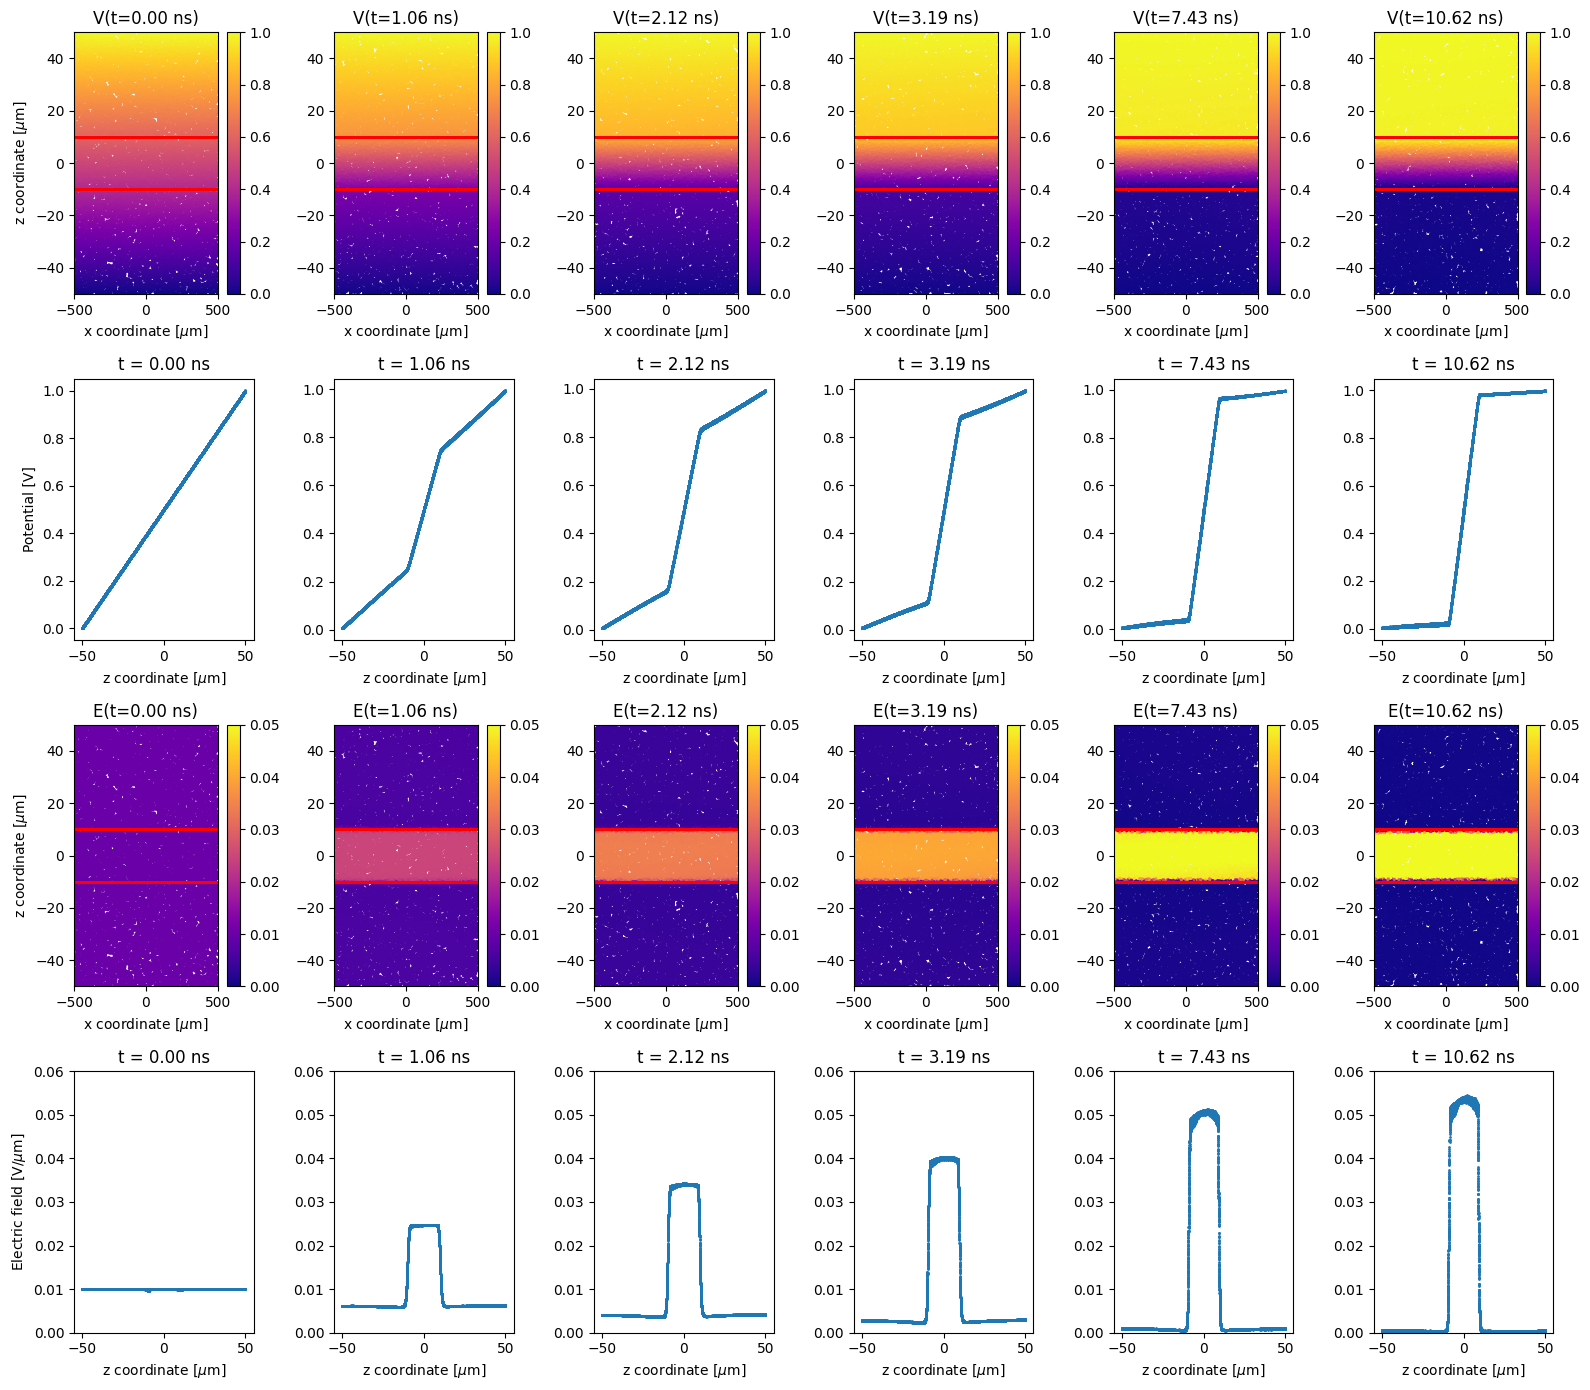

In [18]:
# PREDICTION
sampled_times = Norm_time( t_min + np.array([ 0, 0.1, 0.2, 0.3, 0.7, 1 ]) * (t_max - t_min) )
n_samples = 20000
plt.figure(figsize=(16,14))
model.eval()
sigma_model.eval()
pde_class = QSM_PDE()

for i_plot, n_t in enumerate(sampled_times, 1):
    real_t = Inv_Norm_time(n_t)
    X_pred = pde_class.gen_PDE_points(model, batch_size=n_samples)
    X_pred[:,0] = n_t * torch.ones_like(X_pred[:,0], device=device)
    X_Sample = X_pred.detach().cpu().numpy()
    #with torch.no_grad():
    X_pred.requires_grad=True
    V_pred = model.forward(X_pred)
    
    q_pred = V_pred
    E_pred = ( (pde_class.get_derivative(V_pred, X_pred, 1)[:,1].unsqueeze(-1)/factor_x)**2 \
              + (pde_class.get_derivative(V_pred, X_pred, 1)[:,2].unsqueeze(-1)/factor_y)**2 \
              + (pde_class.get_derivative(V_pred, X_pred, 1)[:,3].unsqueeze(-1)/factor_z)**2 ) ** (1/2)
    q_pred = q_pred.detach().cpu().numpy()
    E_pred = E_pred.detach().cpu().numpy()

    v_min = 0
    v_max = V0
    
    # ====== VOLT ======
    plt.subplot(4, len(sampled_times), i_plot)
    im0=plt.scatter(Inv_Norm_x(X_Sample[:, 1]), Inv_Norm_z(X_Sample[:, 3]), c=q_pred, s=2, cmap='plasma', vmin=v_min, vmax=v_max)
    # linea rossa condensatore piastre
    x_vals = x_min + (x_max - x_min) * np.random.rand(1000)
    z_val  = z_max - L/2 + d/2
    plt.scatter(x_vals, np.full_like(x_vals, z_val), c="red", s=1)
    z_val  = z_min+L/2 - d/2
    plt.scatter(x_vals, np.full_like(x_vals, z_val), c="red", s=1)
    plt.title(f"V(t={real_t:.2f} ns)")
    plt.xlabel("x coordinate [$\\mu$m]")
    if i_plot == 1:
        plt.ylabel("z coordinate [$\\mu$m]")
    plt.xlim(x_min, x_max)
    plt.ylim(z_min, z_max)
    plt.colorbar(im0)
    plt.tight_layout()
    
    # ====== VOLT UNIDIM ======
    plt.subplot(4, len(sampled_times), len(sampled_times) + i_plot)
    im2=plt.scatter(Inv_Norm_z(X_Sample[:, 3]), q_pred, s=1)
    plt.title(f"t = {real_t:.2f} ns")
    if i_plot == 1:
        plt.ylabel("Potential [V]")
    plt.xlabel("z coordinate [$\\mu$m]")
    plt.tight_layout()

    # ====== ELECTRIC ======
    v_min = 0
    v_max = (V0 - 0) / ( norm_z_max - norm_z_min ) / factor_z
    plt.subplot(4, len(sampled_times), 2*len(sampled_times) + i_plot)
    im1=plt.scatter(Inv_Norm_x(X_Sample[:, 1]), Inv_Norm_z(X_Sample[:, 3]), c=E_pred, s=2, cmap='plasma', vmin=0, vmax=0.05)
    # linea rossa condensatore piastre
    x_vals = x_min + (x_max - x_min) * np.random.rand(1000)
    z_val  = z_max - L/2 + d/2
    plt.scatter(x_vals, np.full_like(x_vals, z_val), c="red", s=1)
    z_val  = z_min + L/2 - d/2
    plt.scatter(x_vals, np.full_like(x_vals, z_val), c="red", s=1)
    plt.title(f"E(t={real_t:.2f} ns)")
    plt.xlabel("x coordinate [$\\mu$m]")
    if i_plot == 1:
        plt.ylabel("z coordinate [$\\mu$m]")
    plt.xlim(x_min, x_max)
    plt.ylim(z_min, z_max)
    plt.colorbar(im1)
    plt.tight_layout()

    # ====== ELECTRIC UNIDIM ======
    plt.subplot(4, len(sampled_times), 3*len(sampled_times) + i_plot)
    im3=plt.scatter(Inv_Norm_z(X_Sample[:, 3]), E_pred, s=1)
    plt.ylim(0,0.06)
    plt.title(f"t = {real_t:.2f} ns")
    if i_plot == 1:
        plt.ylabel("Electric field [V/$\\mu$m]")
    plt.xlabel("z coordinate [$\\mu$m]")
    plt.tight_layout()

plt.savefig("plot_c_pred.jpg", format="jpg", dpi=300)
plt.show()

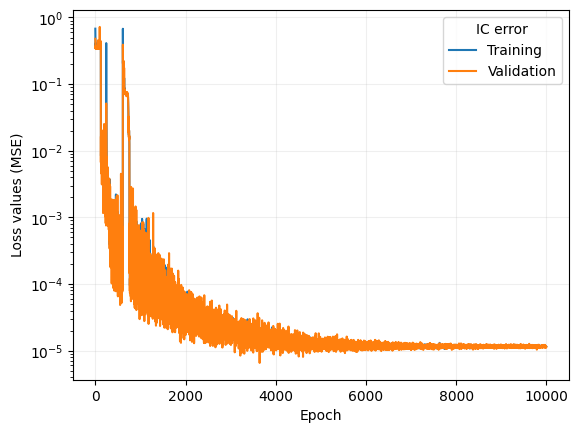

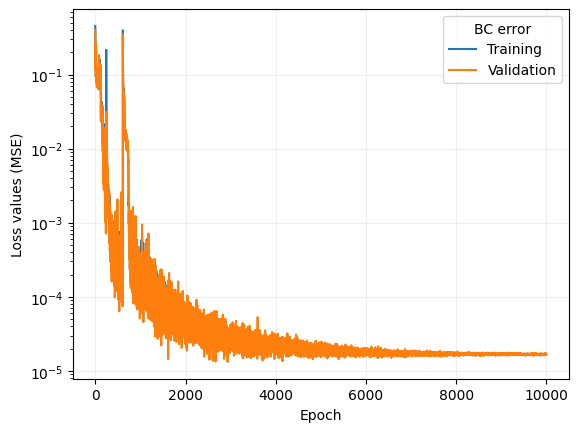

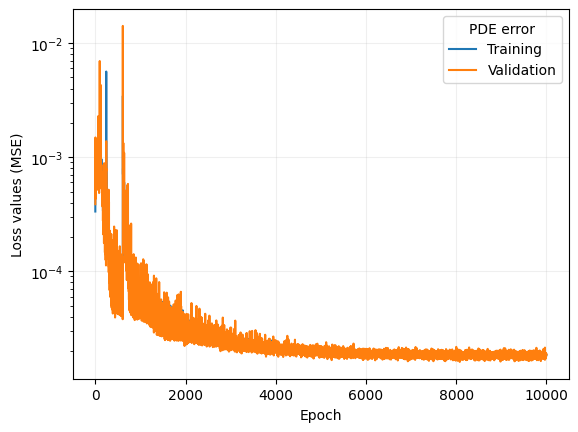

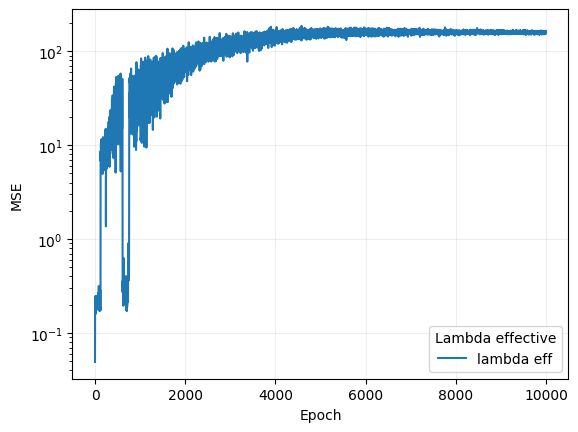

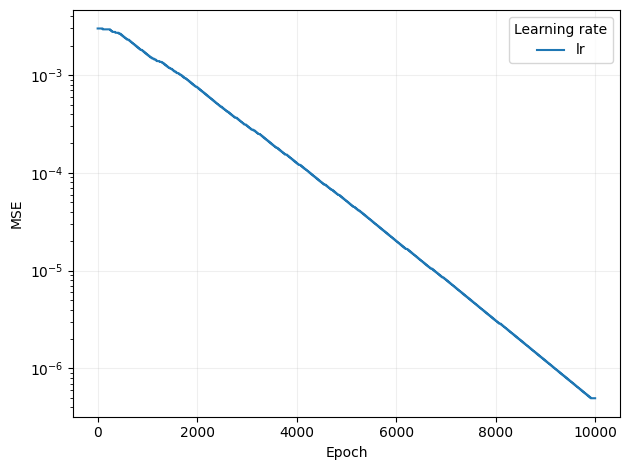

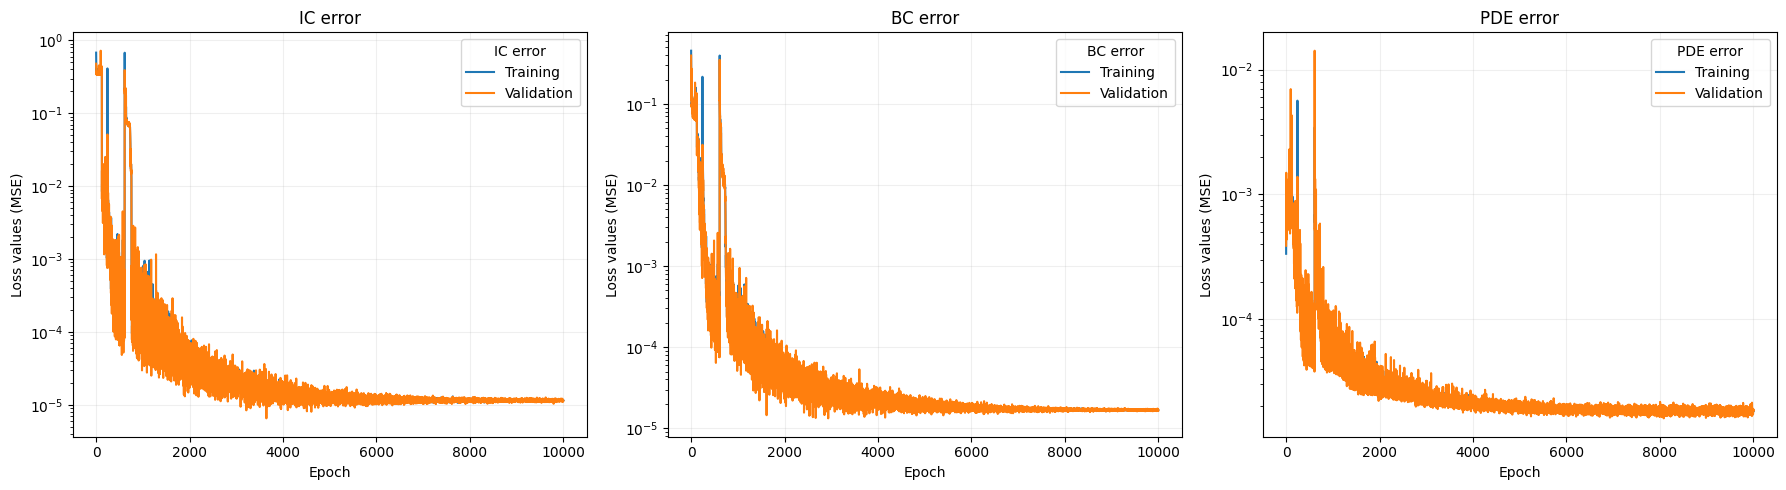

In [20]:
history = checkpoint["history"]

# PLOTS OF TRAINING AND VALIDATION STEPS
# plot IC
plt.plot([pair[0] for pair in history], label="Training")
plt.plot([pair[2] for pair in history], label="Validation")
plt.legend(title="IC error")
plt.xlabel("Epoch")
plt.ylabel("Loss values (MSE)")
plt.grid(alpha=0.2)
plt.yscale("log")
plt.savefig("plot_c_IC.jpg", format="jpg", dpi=300)
plt.show()
# plot BC
plt.plot([pair[8] for pair in history], label="Training")
plt.plot([pair[9] for pair in history], label="Validation")
plt.legend(title="BC error")
plt.xlabel("Epoch")
plt.ylabel("Loss values (MSE)")
plt.grid(alpha=0.2)
plt.yscale("log")
plt.savefig("plot_c_BC.jpg", format="jpg", dpi=300)
plt.show()
# plot PDE CONDITIONS
plt.plot([np.maximum(pair[1]/1e3, 1e-6) for pair in history], label="Training")
plt.plot([np.maximum(pair[3]/1e3, 1e-6) for pair in history], label="Validation")
plt.legend(title="PDE error")
plt.xlabel("Epoch")
plt.ylabel("Loss values (MSE)")
plt.grid(alpha=0.2)
plt.yscale("log")
plt.savefig("plot_c_PDE.jpg", format="jpg", dpi=300)
plt.show()
# plot LAMBDA EFFECTIVE
plt.plot([pair[6] for pair in history], label="lambda eff")
plt.legend(title="Lambda effective")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.grid(alpha=0.2)
plt.yscale("log")
plt.show()
# plot LEARNING RATE
plt.plot([pair[7] for pair in history], label="lr")
plt.legend(title="Learning rate")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.grid(alpha=0.2)
plt.yscale("log")
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 3, figsize=(18, 5))
# --- IC ---
axs[0].plot([pair[0] for pair in history], label="Training")
axs[0].plot([pair[2] for pair in history], label="Validation")
axs[0].legend(title="IC error")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss values (MSE)")
axs[0].set_yscale("log")
axs[0].set_title("IC error")
axs[0].grid(alpha=0.2)
# --- BC ---
axs[1].plot([pair[8] for pair in history], label="Training")
axs[1].plot([pair[9] for pair in history], label="Validation")
axs[1].legend(title="BC error")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss values (MSE)")
axs[1].set_yscale("log")
axs[1].set_title("BC error")
axs[1].grid(alpha=0.2)
# --- PDE CONDITIONS ---
plt.plot([np.maximum(pair[1]/1e3, 1e-6) for pair in history], label="Training")
plt.plot([np.maximum(pair[3]/1e3, 1e-6) for pair in history], label="Validation")
axs[2].legend(title="PDE error")
axs[2].set_xlabel("Epoch")
axs[2].set_ylabel("Loss values (MSE)")
axs[2].set_yscale("log")
axs[2].set_title("PDE error")
axs[2].grid(alpha=0.2)
plt.tight_layout()
plt.savefig("plot_c_history.jpg", format="jpg", dpi=300)
plt.show()